# Data Preprocessing
*from Python Machine Learning by Sebastian Raschka under the MIT License (MIT)*

This code might be directly from the book, mine, or a mix.

### Categorical data operations

In [3]:
import pandas as pd
import numpy as np

df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
df['classlabel'] = df['classlabel'].map(class_mapping)

pd.get_dummies(df[['price', 'color', 'size']])

,price,color_blue,color_green,color_red,size_L,size_M,size_XL
0,10.1,0,1,0,0,1,0
1,13.5,0,0,1,1,0,0
2,15.3,1,0,0,0,0,1


### Partitioning and scaling

In [5]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [7]:
# Standarization

from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [8]:
# L1 regularized logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


## Sequential selection algorithms

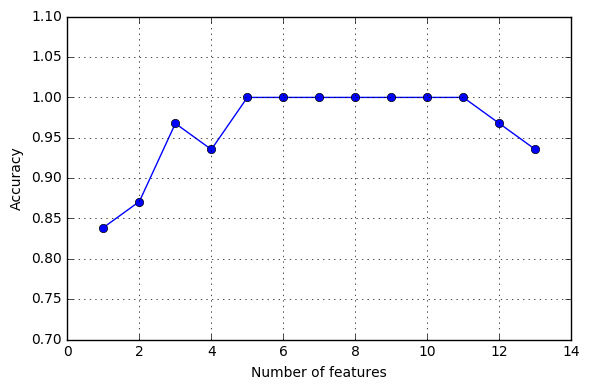

In [10]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

### Feature importance

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


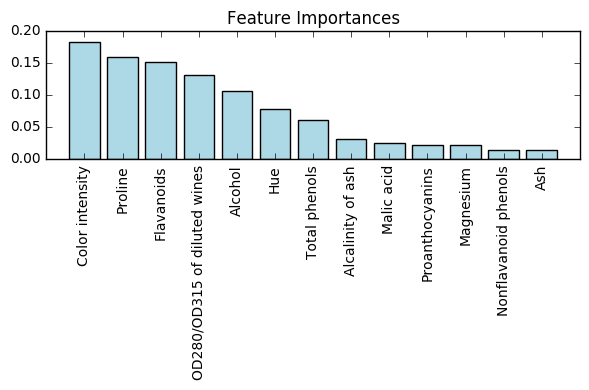

In [12]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()
